In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import scipy.stats as stats
from tabulate import tabulate
import string
import glob
import os
from openpyxl import load_workbook
import openpyxl

In [4]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [5]:
color_map_name = "nipy_spectral"
cmap = matplotlib.colormaps[color_map_name]  
full_group_name2idx_map = {
    "primates": 0,
    "mammals": 1, 
    "birds": 2,
    "reptiles": 3,
    "fish": 4,
    "arthropods": 5,
    "nematodes": 6,
    "plants": 7,
    "fungi": 8,
    "others": 9
}

vertebrate_group_name2idx_map = {
    "primates": 0,
    "mammals": 1, 
    "birds": 2,
    "reptiles": 3,
    "fish": 4
}

animal_group_name2idx_map = {
    "primates": 0,
    "mammals": 1, 
    "birds": 2,
    "reptiles": 3,
    "fish": 4,
    "arthropods": 5,
    "nematodes": 6
}

def get_color_index(num_groups, group_name_index):
    """Calculate an decimal index between (0.05, 1)"""
    return 1 - (0.05+ (1-0.05) / num_groups * group_name_index)


### Helper functions used to load regression results from R scripts

In [6]:
## helper functions to plot data generated from R
def load_and_plot_r_regression_output(r_filename, x_bounds, text_pos=(0.7, 0.85), fontsize=15, log_scale=True, ax=None, 
                                      label=None, linestyle="dashed", linewidth=1, alpha=1, color="black", add_text_to_figure=True):
    df = pd.read_csv(r_filename)
    intercept = df["intercept"].to_numpy()[0]
    slope = df["slope"].to_numpy()[0]
    p_val_slope = df["slope.p"].to_numpy()[0]
    if log_scale is True:
        plot_regression_line_on_logscale(intercept, slope, x_bounds, text_pos=text_pos, fontsize=fontsize, p_value=p_val_slope, ax=ax, 
                                         label=label, linestyle=linestyle, linewidth=linewidth, alpha=alpha, color=color)
    else:
        plot_regression_line_on_linearscale(intercept, slope, x_bounds, text_pos=text_pos, fontsize=fontsize, p_value=p_val_slope, ax=ax, 
                                            label=label, linestyle=linestyle, linewidth=linewidth, alpha=alpha, color=color)
    if add_text_to_figure:
        add_text_helper(ax, slope, p_val_slope, text_pos, fontsize, font_weight="normal")
        
    return [intercept, slope]
    
def plot_regression_line_on_linearscale(intercept, slope, x_bounds, text_pos=(0.7, 0.85), fontsize=15, p_value=None, ax=None, 
                                        label=None, linestyle="dashed", linewidth=1, alpha=1, color="black"):
    if ax is None:
        fig, ax = plt.subplots()
    ax.axline((0, intercept), slope=slope, linestyle=linestyle, linewidth=linewidth, label=label, alpha=alpha, color=color)
    # if p_value:
    #     p_val_str = f"{p_value:.2f}" if p_value > 0.05 else f"{p_value:.1e}"
    #     text = f"slope: {slope:.3f}\np-value: {p_val_str}"
    # else:
    #     text = f"slope: {slope:.3f}"
    # ax.text(text_pos[0], text_pos[1], text, transform=ax.transAxes, fontsize=fontsize, color=(0.66, 0.66, 0.66))
    
def plot_regression_line_on_logscale(intercept, slope, x_bounds, text_pos=(0.7, 0.85), fontsize=15, p_value=None, ax=None, 
                                     label=None, linestyle="dashed", linewidth=1, alpha=1, color="black"):
    if ax is None:
        fig, ax = plt.subplots()
    y = np.power(10, intercept) * np.power(x_bounds, slope)
    ax.plot(x_bounds, y, linestyle=linestyle, linewidth=linewidth, label=label, alpha=alpha, color=color)

def generate_p_value_str(p_value):
    if p_value <= 0.001:
        stars =  "****"
    elif p_value <= 0.01:
        stars = "***"
    elif p_value <= 0.05:
        stars = "*"
    p_val_str = f"{p_value:.2f}" if p_value > 0.05 else f"{p_value:.1e}{stars}"
    return p_val_str

def add_text_helper(ax, slope, p_value, text_pos, fontsize, font_weight):
    if p_value:
        p_val_str = generate_p_value_str(p_value)
        # text = rf"$\it{{P}}$={p_val_str}"
        text = f"slope = {slope:.3f}\n" + rf"$\it{{P}}$ = {p_val_str}" 
    else:
        text = f"slope = {slope:.3f}"
    font_weight = "normal" if p_value > 0.05 else "bold"
    ax.text(text_pos[0], text_pos[1], text, transform=ax.transAxes, fontsize=fontsize, fontweight="normal", color=(0.4, 0.4, 0.4))

In [7]:
df_all = pd.read_csv("output/processed_mutation_rate_estimate.csv")
vertebrate_set = set(vertebrate_group_name2idx_map.keys())
vertebrate_mask = df_all["group2"].isin(vertebrate_set)
df_vertebrate = df_all[vertebrate_mask]
df_vertebrate.to_csv("output/df_vertebrate.csv")
assert set(df_vertebrate["group2"].unique()) == vertebrate_set
print(f"there are {len(df_all)} species with snp mutation rate estimates AND Ne estimates in the dataset\nthere are {len(df_vertebrate)} vertebrate species")

there are 102 species with snp mutation rate estimates AND Ne estimates in the dataset
there are 72 vertebrate species


## Figure 2

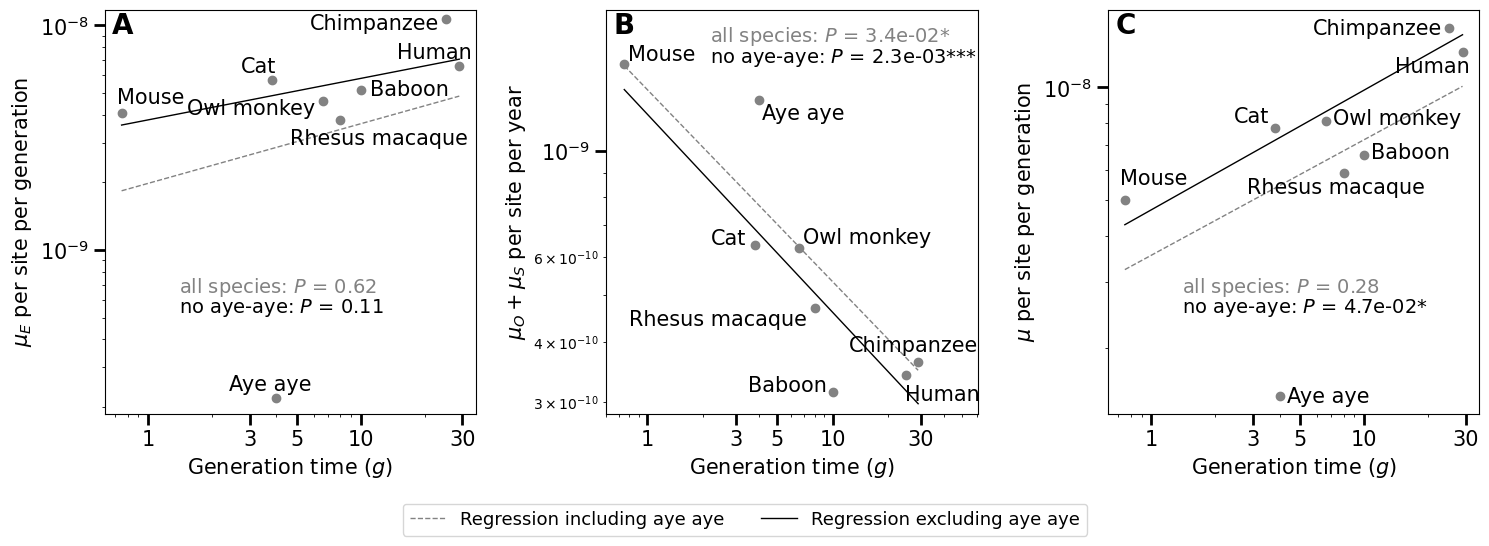

In [43]:
def plot_slope_and_intercept_regression(data_filename, ax=None, is_supplementary_figure=False):
    def plot_fig2_regression_helper(generation_time, y, x_bounds, r_filename, text_fontsize=15,
                                    text_pos=(0.7, 0.85), linestyle="solid", color="blue", ax=None):
        if ax is None:
            fig, ax = plt.subplots()
        ax.scatter(generation_time, y, color=color)
        ax.set_xscale("log")
        ax.set_yscale("log")
        if r_filename is not None:
            r_filename_ayeaye = f"{r_filename}.csv"
            r_filename_noayeaye = f"{r_filename}_no_ayeaye.csv"
            load_and_plot_r_regression_output(r_filename_ayeaye, x_bounds, text_pos=text_pos, fontsize=text_fontsize, 
                                              log_scale=True, ax=ax, label="Regression including aye aye", linestyle="dashed", 
                                              linewidth=1, alpha=1, color=color, add_text_to_figure=False)
            load_and_plot_r_regression_output(r_filename_noayeaye, x_bounds, text_pos=text_pos, fontsize=text_fontsize, 
                                              log_scale=True, ax=ax, label="Regression excluding aye aye", linestyle=linestyle, 
                                              linewidth=1, alpha=1, color="black", add_text_to_figure=False)
            add_text_to_figure2_helper(r_filename_ayeaye, r_filename_noayeaye, ax, text_pos, text_fontsize, "normal", color)

    def add_text_to_figure2_helper(r_filename_ayeaye, r_filename_noayeaye, ax, text_pos, fontsize, font_weight, color_all_species):
        p_val_str = []
        colors = [color_all_species, "black"]
        for i, f in enumerate([r_filename_ayeaye, r_filename_noayeaye]):
            df = pd.read_csv(f)
            p_val_slope = df["slope.p"].to_numpy()[0]
            if p_val_slope:
                p_val_str = generate_p_value_str(p_val_slope)
                text = rf"$\it{{P}}$ = {p_val_str}"
                text = "all species: " + text if i == 0 else "no aye-aye: " + text
                ax.text(text_pos[0], text_pos[1] - i * 0.05, text, transform=ax.transAxes, fontsize=fontsize, fontweight=font_weight, color=colors[i])


    if ax is None:
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    df = pd.read_csv(data_filename)
    data_filename_suffix = "_".join(os.path.basename(data_filename).split(".")[0].split("_")[3:5])
    alpha_value = "_".join(os.path.basename(data_filename).split(".")[0].split("_")[5:])
    species, intercept, slope, mu_per_generation = df["species_name"].to_numpy(), df["intercept"].to_numpy(), df["slope"].to_numpy(), df["mu_per_generation"].to_numpy()
    generation_time = df["generation_time"].to_numpy()

    r_file_dir = "output/r/figure2_df/individual_regressions"
    slope_r_filename_prefix = f"{r_file_dir}/{data_filename_suffix}_slope_regression_output_{alpha_value}" #.csv"
    intercept_r_filename_prefix = f"{r_file_dir}/{data_filename_suffix}_intercept_regression_output_{alpha_value}" #.csv"
    mu_gen_r_filename_prefix = f"{r_file_dir}/{data_filename_suffix}_per_gen_regression_output_{alpha_value}" #.csv"

    x_bounds = np.min(generation_time), np.max(generation_time)
    
    p_val_text_fontsize = 14  
    text_label_font_size = 15

    set_text_label(ax[0], species, generation_time, intercept, data_filename_suffix, alpha_value, is_supplementary_figure, text_label_font_size, "left")
    set_text_label(ax[1], species, generation_time, slope, data_filename_suffix, alpha_value, is_supplementary_figure, text_label_font_size, "middle")
    set_text_label(ax[2], species, generation_time, mu_per_generation, data_filename_suffix, alpha_value, is_supplementary_figure, text_label_font_size, "right")
    
    # other grey shades: "#222021", "#48494D"
    grey_color = "#828282"
    text_pos = (0.2, 0.3) if not is_supplementary_figure else (0.2, 0.4)
    plot_fig2_regression_helper(generation_time, intercept, x_bounds, intercept_r_filename_prefix, 
                                text_fontsize=p_val_text_fontsize, text_pos=text_pos, color=grey_color, ax=ax[0])
    text_pos = (0.28, 0.92) if not is_supplementary_figure else (0.35, 0.928)
    plot_fig2_regression_helper(generation_time, slope, x_bounds, slope_r_filename_prefix, 
                                text_fontsize=p_val_text_fontsize, text_pos=text_pos, color=grey_color, ax=ax[1])
    plot_fig2_regression_helper(generation_time, mu_per_generation, x_bounds, mu_gen_r_filename_prefix, 
                                text_fontsize=p_val_text_fontsize, text_pos=(0.2, 0.3), color=grey_color, ax=ax[2])


    def set_axis_limits(ax, intercept, slope, mu_generation, dataset_name):
        
        [baboon_dataset_name, aye_aye_dataset_name] = dataset_name.split("_")
        intercept_min, intercept_max = np.min(intercept), np.max(intercept)
        ax0_ymax = 2.5e-8 if aye_aye_dataset_name == "versoza" else 1.1 * intercept_max 
        ax[0].set_ylim([2e-10, 2e-8])
        ax[0].set_ylim([0.85 * intercept_min, ax0_ymax])
        
        slope_min, slope_max = np.min(slope), np.max(slope)
        ax[1].set_ylim([2e-10, 2e-9])
        ax[1].set_ylim([0.9 * slope_min, 1.3 * slope_max])
        ax[1].set_xlim([0.8 * x_bounds[0], 2.1 * x_bounds[1]])#0.9 * slope_min, 1.3 * slope_max])

        mu_min = np.min(mu_generation)
        if aye_aye_dataset_name == "versoza":
            ax[2].set_ylim([0.8 * mu_min, 2e-8])#0.9 * slope_min, 1.3 * slope_max])
        # ax[2].set_ylim([1e-9, 2e-8])#0.9 * slope_min, 1.3 * slope_max])

    set_axis_limits(ax, intercept, slope, mu_per_generation, data_filename_suffix)


def format_figure2_x_axis_label(ax, tick_label_font_size, axis_label_font_size, tick_location):
    ax.tick_params(axis='both', which='major', labelsize=tick_label_font_size, width=2, length=8)
    ax.set_xlabel(r"Generation time ($g$)", fontsize=axis_label_font_size)
    ax.set_xticks(tick_location, labels=tick_location)

def format_figure2_y_axis_label(ax, axis_label_font_size, y_label):
    ax.set_ylabel(y_label, fontsize=axis_label_font_size)

def format_figure2_y_ticks(ax, tick_label_font_size=15):
    ax.tick_params(axis='both', which='major', labelsize=tick_label_font_size, width=2, length=8)

def plot_figure_2(save_figure=True):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    data_filename = "output/figure2_point_estimates_wang_wang_variable_alpha.csv"
    figure_2_name = f"figures/figure2_wang_wang_variable_alpha.pdf"
    plot_slope_and_intercept_regression(data_filename, ax=ax, is_supplementary_figure=False)

    tick_label_font_size, axis_label_font_size = 15, 15
    tick_location = [1,3,5,10,30]
    y_label = rf"$\mu_E$ per site per generation"
    format_figure2_x_axis_label(ax[0], tick_label_font_size, axis_label_font_size, tick_location)
    format_figure2_y_axis_label(ax[0], axis_label_font_size, y_label)
    handles, labels = ax[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0), fontsize=13, ncol=2)
    # [h.set_color('red') for h in handles]

    y_label = r"$\mu_{O} + \mu_{S}$ per site per year"
    format_figure2_x_axis_label(ax[1], tick_label_font_size, axis_label_font_size, tick_location)
    format_figure2_y_axis_label(ax[1], axis_label_font_size, y_label)

    y_label = rf"$\mu$ per site per generation"
    format_figure2_x_axis_label(ax[2], tick_label_font_size, axis_label_font_size, tick_location)
    format_figure2_y_axis_label(ax[2], axis_label_font_size, y_label)

    for n, axis in enumerate(ax.flatten()):
        axis.text(0.02, 0.94, string.ascii_uppercase[n], transform=axis.transAxes, size=20, weight='bold')

    fig.tight_layout()
    if save_figure:
        fig.savefig(figure_2_name, bbox_inches='tight')

plot_figure_2(save_figure=False)


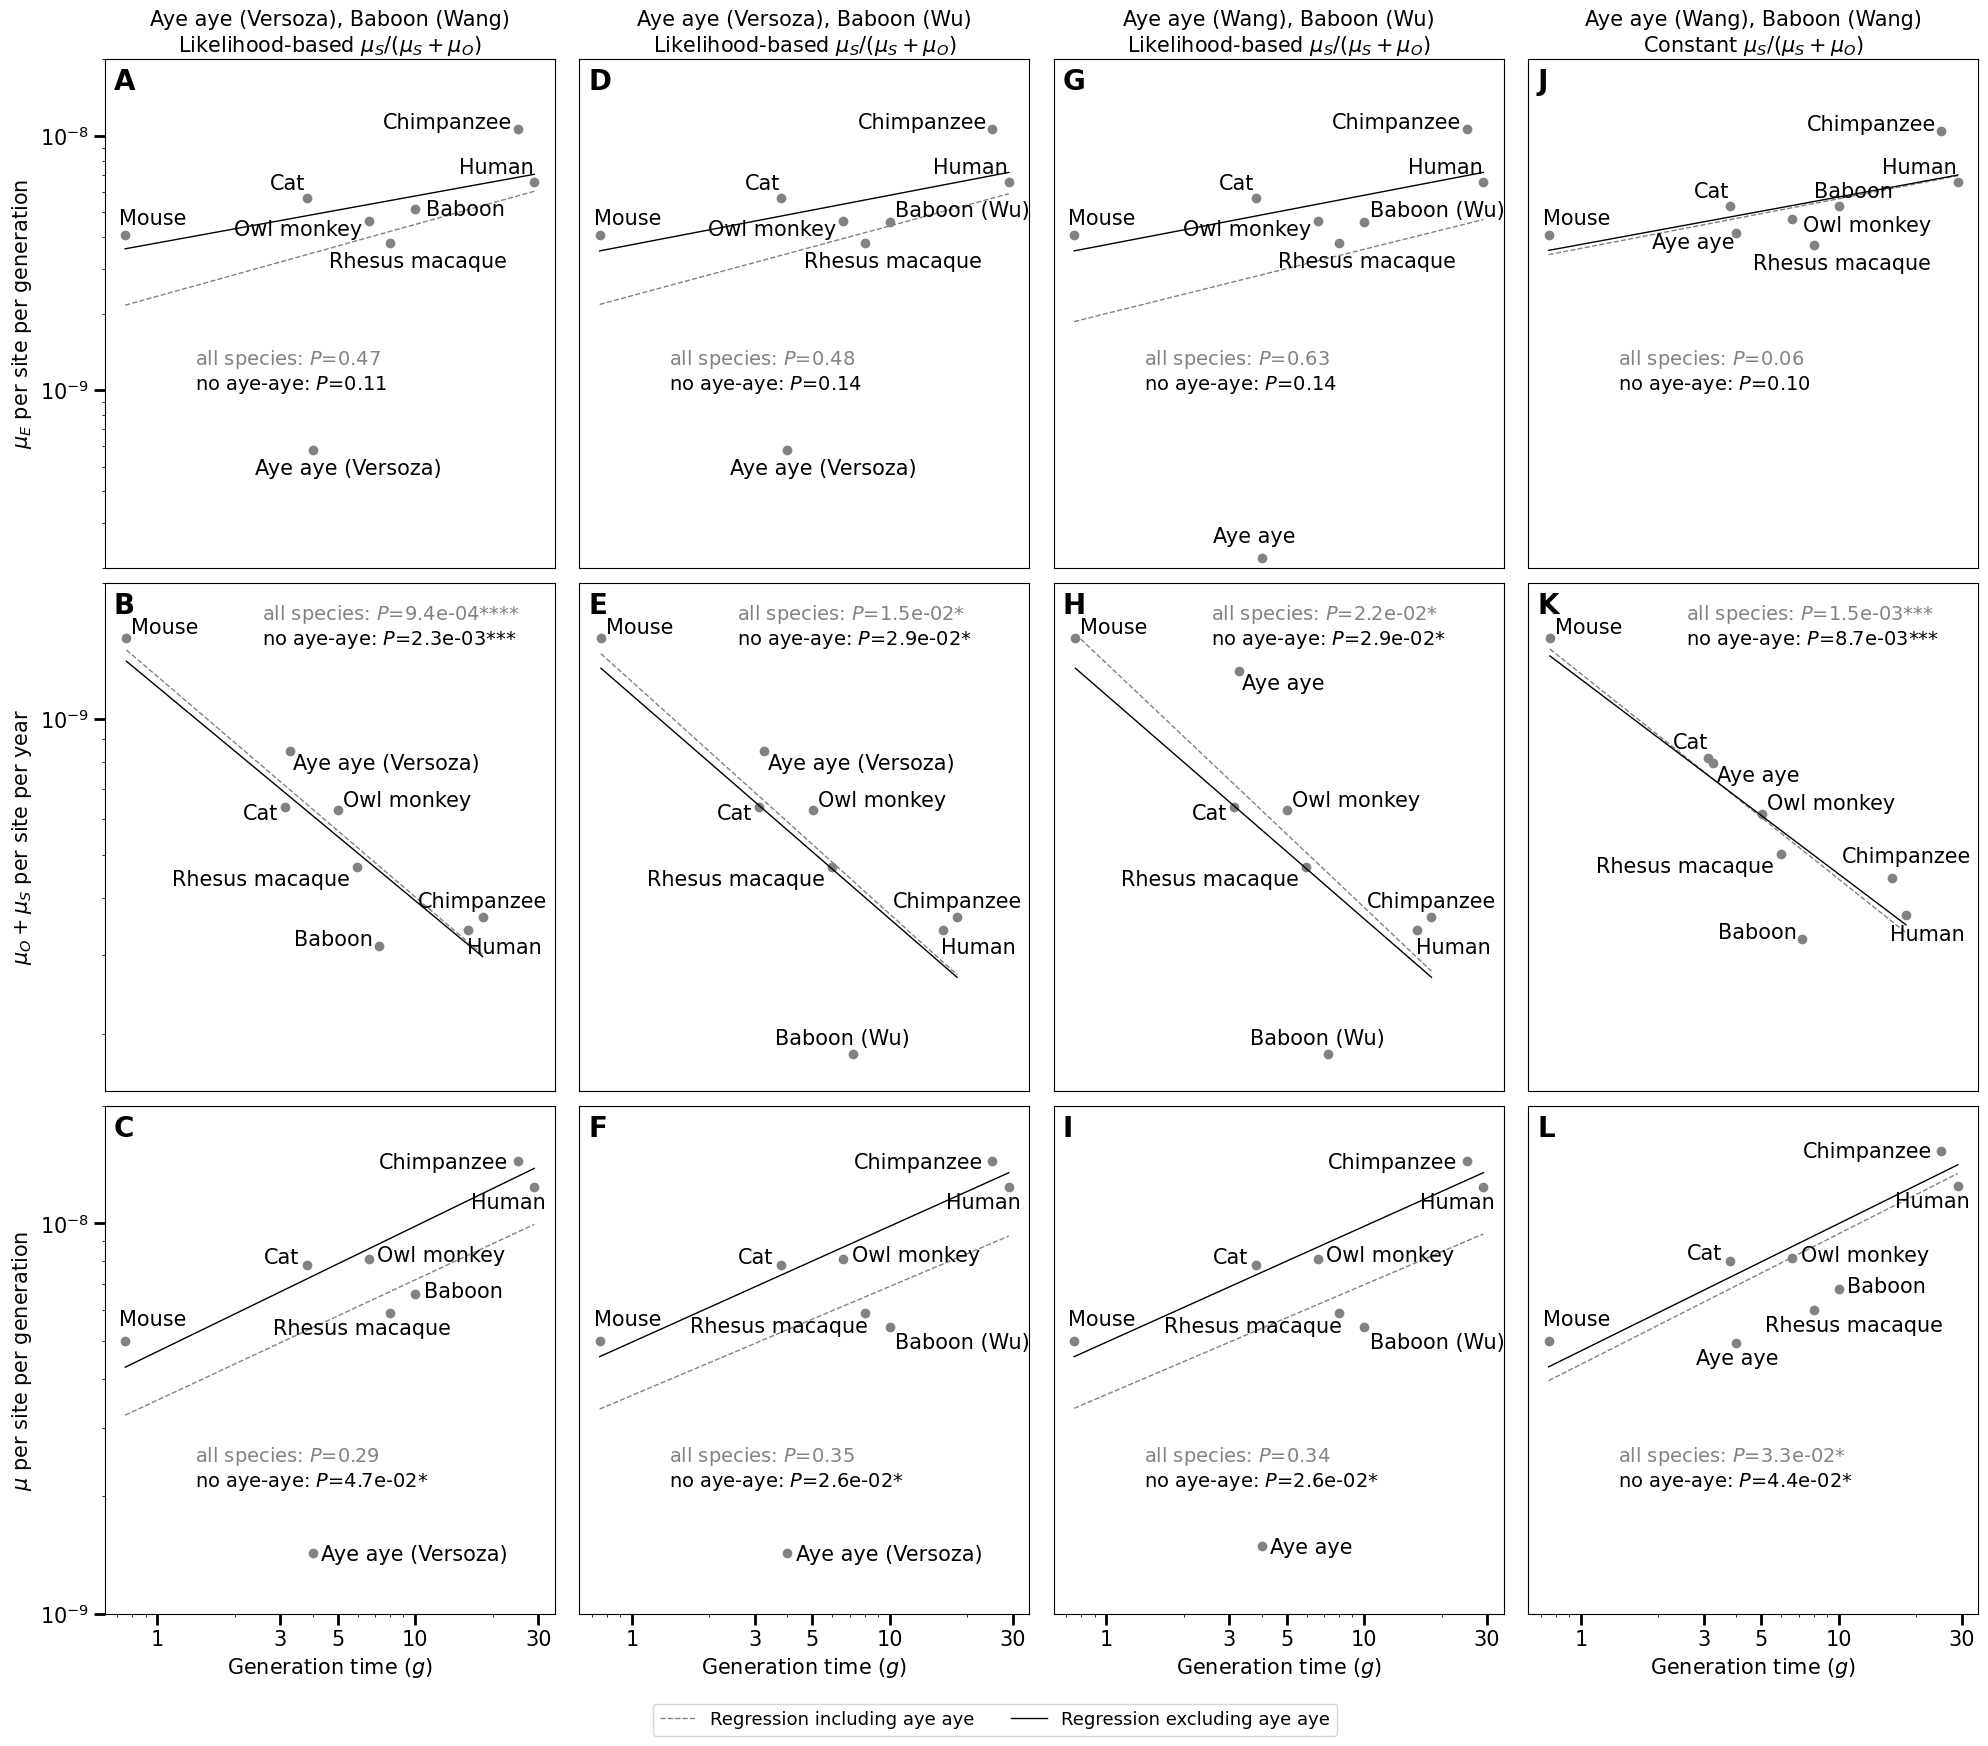

In [41]:
def set_supplementary_figure_axis_limits(ax):
    for c in range(4):
        ax[0, c].set_ylim([2e-10, 2e-8])
        ax[1, c].set_ylim([1.5e-10, 2e-9])
        ax[2, c].set_ylim([1e-9, 2e-8])

def plot_supplementary_figure_slope_intercept_regressions(save_figure):
    num_rows, num_cols = 3, 4
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(20, 17))


    wang_versoza_filename = "output/figure2_point_estimates_wang_versoza_variable_alpha.csv"
    plot_slope_and_intercept_regression(wang_versoza_filename, ax[:, 0], is_supplementary_figure=True)

    wu_versoza_filename = "output/figure2_point_estimates_wu_versoza_variable_alpha.csv"
    plot_slope_and_intercept_regression(wu_versoza_filename, ax[:, 1], is_supplementary_figure=True)

    wu_wang_filename = "output/figure2_point_estimates_wu_wang_variable_alpha.csv"
    plot_slope_and_intercept_regression(wu_wang_filename, ax[:, 2], is_supplementary_figure=True)

    wang_wang_default_alpha_filename = "output/figure2_point_estimates_wang_wang_default_alpha.csv"
    plot_slope_and_intercept_regression(wang_wang_default_alpha_filename, ax[:,3], is_supplementary_figure=True)

    tick_label_font_size, axis_label_font_size = 15, 15
    tick_location = [1,3,5,10,30]
    y_label = rf"$\mu_E$ per site per generation"
    format_figure2_y_axis_label(ax[0,0], axis_label_font_size, y_label)

    y_label = r"$\mu_{O} + \mu_{S}$ per site per year"
    format_figure2_y_axis_label(ax[1,0], axis_label_font_size, y_label)

    y_label = rf"$\mu$ per site per generation"
    format_figure2_y_axis_label(ax[2,0], axis_label_font_size, y_label)

    for i in range(num_cols):
        format_figure2_x_axis_label(ax[2,i], tick_label_font_size, axis_label_font_size, tick_location)
        
    for i in range(num_rows):
        ax[i,0].tick_params(axis='both', which='major', labelsize=15, width=2, length=8)
        # format_y_axis_label(ax[i,0], axis_label_font_size, y_label)

    for c in range(num_cols):
        for r in range(num_rows - 1):
            ax[r, c].set_xticklabels([])
            ax[r, c].set_xticks([])
            ax[r, c].set_xticks([], minor=True)
    for c in range(1,num_cols):
        for r in range(num_rows):
            ax[r, c].set_yticklabels([])
            ax[r, c].set_yticks([])
            ax[r, c].set_yticks([], minor=True)
    
    set_supplementary_figure_axis_limits(ax)

    for n, axis in enumerate(np.transpose(ax).flatten()):
        axis.text(0.02, 0.94, string.ascii_uppercase[n], transform=axis.transAxes, size=20, weight='bold')

    ax[0, 0].set_title("Aye aye (Versoza), Baboon (Wang)\n"
                       r"Likelihood-based $\mu_S/(\mu_S + \mu_O)$", fontsize=15)
    ax[0, 1].set_title("Aye aye (Versoza), Baboon (Wu)\n"
                       r"Likelihood-based $\mu_S/(\mu_S + \mu_O)$", fontsize=15)
    ax[0, 2].set_title("Aye aye (Wang), Baboon (Wu)\n"
                       r"Likelihood-based $\mu_S/(\mu_S + \mu_O)$", fontsize=15)
    ax[0, 3].set_title("Aye aye (Wang), Baboon (Wang)\n"
                       r"Constant $\mu_S/(\mu_S + \mu_O)$", fontsize=15)

    handles, labels = ax[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0), fontsize=13, ncol=2)

    fig.tight_layout()
    figure_name = "figures/supplementary_slope_intercept_regression.pdf"
    if save_figure:
        fig.savefig(figure_name, bbox_inches='tight')
    fig.tight_layout()

def set_text_label(ax, species, generation_time, y, dataset_name, alpha_value, is_supplementary_figure=False, text_label_size=15, figure_pos="left"):
    standard_mod = [1.05, 1.02]
    if not is_supplementary_figure:
        label_position_dict = {
            "left": {"Mouse": [0.95, 1.1], "Owl monkey": [0.23, 0.87], "Human": [0.51, 1.08], 
                     "Chimpanzee": [0.23, 0.9], "Cat": [0.72, 1.08], "Baboon": [1.1, 0.95], 
                     "Rhesus macaque": [0.58, 0.78], "Aye aye": [0.6, 1.08]}, 
            "middle": {"Cat": [0.58, 1], "Aye aye": [1.04, 0.91], "Rhesus macaque": [0.1, 0.92], 
                      "Baboon": [0.35, 1], "Human": [0.85, 0.83], "Chimpanzee": [0.49, 1.12]},
            "right": {"Cat": [0.64, 1.03], "Aye aye": [1.08, 0.96], "Rhesus macaque": [0.35, 0.88], 
                      "Baboon": [1.08, 0.98], "Human": [0.48, 0.88], "Chimpanzee": [0.23, 0.96], 
                      "Owl monkey": [1.08, 0.98], "Mouse": [0.95, 1.1]}
        }
    else:
        label_position_dict = {
            "left": {"Mouse": [0.95, 1.1], "Owl monkey": [0.3, 0.88], "Human": [0.51, 1.08], 
                     "Chimpanzee": [0.3, 1], "Cat": [0.72, 1.08], "Baboon": [1.1, 0.95], 
                     "Rhesus macaque": [0.58, 0.8], "Aye aye": [0.65, 1.15]}, 
            "middle": {"Cat": [0.65, 0.94], "Aye aye": [1.04, 0.91], "Rhesus macaque": [0.15, 0.91], 
                      "Baboon": [0.42, 1], "Human": [0.85, 0.83], "Chimpanzee": [0.6, 1.12]},
            "right": {"Cat": [0.68, 1.01], "Aye aye": [1.08, 0.96], "Rhesus macaque": [0.35, 0.88], 
                      "Baboon": [1.08, 0.98], "Human": [0.57, 0.88], "Chimpanzee": [0.29, 0.96], 
                      "Mouse": [0.95, 1.1], "Owl monkey": [1.08, 0.98]}
        }
        
        [baboon_dataset_name, aye_aye_dataset_name] = dataset_name.split("_")
        if alpha_value == "default_alpha":
            label_position_dict["left"]["Mouse"] = [0.95, 1.1]
            label_position_dict["left"]["Owl monkey"] = [1.1, 0.9]
            label_position_dict["left"]["Aye aye"] = [0.47, 0.87]
            label_position_dict["left"]["Baboon"] = [0.8, 1.08]

            label_position_dict["middle"]["Chimpanzee"] = [0.6, 1.08]
            label_position_dict["middle"]["Cat"] = [0.7, 1.05]
            label_position_dict["middle"]["Human"] = [0.85, 0.88]
            
            label_position_dict["right"]["Rhesus macaque"] = [0.65, 0.88]
            label_position_dict["right"]["Aye aye"] = [0.7, 0.88]
            
        if aye_aye_dataset_name == "versoza":
            label_position_dict["left"]["Aye aye"] = [0.6, 0.8]
            
        if baboon_dataset_name == "wu":
            label_position_dict["left"]["Baboon"] = [1.05, 1.05]

            label_position_dict["middle"]["Baboon"] = [0.45, 1.05]
            
            label_position_dict["right"]["Baboon"] = [1.05, 0.88]
            label_position_dict["right"]["Rhesus macaque"] = [0.21, 0.89]
    
        
    for i, s in enumerate(species):
        if s == "Baboon_wu":
            species_label = "Baboon"
            text_label = "Baboon (Wu)"
        elif s == "Aye_aye_versoza":
            species_label = "Aye aye"
            text_label = "Aye aye (Versoza)"
        else:
            species_label = " ".join(s.split("_"))
            text_label = species_label

        try:
            x_mod, y_mod = label_position_dict[figure_pos][species_label]
        except KeyError:
            x_mod, y_mod = standard_mod
        ax.text(x_mod * generation_time[i], y_mod * y[i], text_label, fontsize=text_label_size)
    

plot_supplementary_figure_slope_intercept_regressions(save_figure=True)

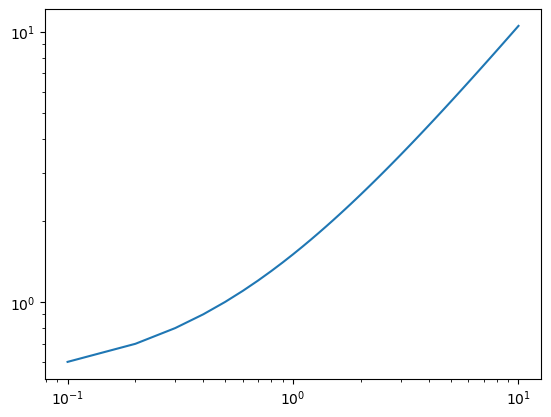

In [17]:
def test():
    x = np.linspace(0.1, 10, 100)
    y = 1 * x + 0.5
    fig, ax = plt.subplots()
    ax.plot(x, y)
    # set log scale for both x and y
    ax.set_xscale("log")
    ax.set_yscale("log")

test()

## Figure 3: Reproductive longevity model
The classical reproductive longetivity model assumes that the per-generation mutation load can be modelled as follows:
$\mu_{\textit{gen}} = B + M(g - p)$ where $B$ is the pre-puberty mutation load, and $M$ is the post-puberty annual mutation load, $g$ is generation time and $p$ is age at puberty. It is assumed that both $B$ and $M$ are constants across species. In human $B=6.35\times 10^{-9}$ and $M=3.5\times 10^{-10}$. In mice, $B=3.75\times 10^{-9}$ and $M=1.64\times 10^{-9}$. The annual mutation rate therefore can be estimated as follows:
$\mu_{\textit{year}} = \frac{B}{g} + M(1-P)$ where $P=\frac{p}{g}$, this was estimated to be 0.419 using mammalian data (see section for supplementary figure 2 for details).

In the relaxed model, we assume that $B=b\cdot g^{\beta}$ and $M = m \cdot g^{\alpha}$. It is estimated that $(m, \alpha) = (1.24\times 10^{-9}, -0.413)$ and $(b, \beta) = (4.0\times 10^{-9}, 0.126)$. The annual mutation rate therefore is modelled as follows:
$\mu_{\textit{year}} = b\cdot g^{\beta-1} + m\cdot g^{\alpha}(1-P)$.


In [13]:
# Dog, Goat, Guinea pig, Siamese fighting fish, Common carp, Domestic cat, Chicken, House mouse, Pig, Alpaca
domesticated_list = ["canis_lupus_familiaris", "capra_hircus", "cavia_aperea", "betta_splendens", "cyprinus_carpio", "felis_catus", "gallus_gallus", "mus_musculus", "sus_scrofa", "vicugna_pacos"]

def compute_residual_sum_of_squares(y_obs, y_pred):
    return np.sum(np.square(y_obs - y_pred))

def u_gen_longevity_fn(B, M, P):
    def f(generation_time):
        return B + M * (generation_time - P * generation_time)
    return f
    
def u_year_longevity_fn(B, M, P):
    def f(generation_time):
        return (B + M * (generation_time - P * generation_time)) / generation_time
    return f

def u_gen_relaxed_fn(b, beta, m, alpha, P):
    def f(generation_time):
        return b * generation_time ** (beta) + m * generation_time ** (alpha) * (generation_time - P * generation_time)
    return f
    
def u_year_relaxed_fn(b, beta, m, alpha, P):
    def f(generation_time):
        return (b * generation_time ** (beta) + m * generation_time ** (alpha) * (generation_time - P * generation_time)) / generation_time
    return f
    
def plot_longevity_model_prediction_per_generation(df, group_name2idx_map, cmap, save_figure=False):
    num_groups = len(group_name2idx_map)
    colors = [cmap(get_color_index(num_groups, i)) for i in range(num_groups)]
    # B_h, M_h = 6.35 * 10**(-9), 3.5 * 10**(-10) # Human values
    B_h, M_h = 6.6 * 10**(-9), 3.63 * 10**(-10) # Human values
    B_m, M_m = 4.08 * 10**(-9), 1.51 * 10**(-9) # Mouse values
    B_a, M_a = 2.19 * 10**(-10), 1.27 * 10**(-9) # Aye aye values
    # B_est, M_est = 8.67946E-09, 3.23132E-10
    P = 0.419
    P_human, P_mice, P_ayeaye = 13/29, 0.15/0.75, 3/4

    # m, alpha = 1.24 * 10 ** (-9), -0.413
    m, alpha = 1.27238 * 10 ** (-9), -0.3955 # likelihood 
    # m, alpha = 1.3387 * 10 ** (-9), -0.39922 # 3:1 ratio
    m_na, alpha_na = 10 ** (-8.9244487), -0.4117793 # no ayeaye
    # m, alpha = 10 ** (-8.9643053), -0.3888803 # no ayeaye and with dog



    # b, beta = 4.0 * 10 ** (-9), 0.126 # original
    # b, beta = 3.60917 * 10 ** (-9), 0.195453 # 3:1 ratio
    b, beta = 1.97884 * 10 ** (-9), 0.265553 # likelihood values
    b_na, beta_na = 10 ** (-8.4210221), 0.1847213 # no ayeaye
    # b, beta = 10 ** (-8.4478644), 0.1995677 # no ayeaye and with dog
    print(b)
    
    g = np.logspace(-0.7, 1.45)
    u_gen_longevity_human = u_gen_longevity_fn(B_h, M_h, P_human)
    u_gen_longevity_mice = u_gen_longevity_fn(B_m, M_m, P_mice)
    u_gen_longevity_ayeaye = u_gen_longevity_fn(B_a, M_a, P_ayeaye)
    u_gen_relaxed = u_gen_relaxed_fn(b, beta, m, alpha, P) #b * g ** (beta) + m * g ** (alpha) * (g - P * g)
    u_gen_relaxed_na = u_gen_relaxed_fn(b_na, beta_na, m_na, alpha_na, P) #b * g ** (beta) + m * g ** (alpha) * (g - P * g)


    g_df = df["generation_time_year"].to_numpy()
    # rss_gen = []
    # for u in [u_gen_longevity_human, u_gen_longevity_mice, u_gen_relaxed]:
    #     rss_gen.append(compute_residual_sum_of_squares(df["u_mean"].to_numpy(), u(g_df)))

    # rss_table_output = [["", "longevity (human)", "longevity (mice)", "flexible"], ["rss (u_gen)"] + [f"{x:.2E}" for x in rss_gen]]
    # print(tabulate(rss_table_output))
    
    fig, ax = plt.subplots(1, 1, figsize=(10,10))
    linewidth = 3
    r_filename = f"./output/r/mu_gen_vs_gen.csv"
    load_and_plot_r_regression_output(r_filename, [g[0], g[-1]], text_pos=(0.08, 0.15), ax=ax, 
                                      label="PGLS regression", linestyle="solid", linewidth=linewidth, alpha=0.8, color="black", add_text_to_figure=False)
    
    ax.scatter(df["generation_time_year"], df["u_mean"], alpha=0.8, color="gray")

    # plot human and mouse values
    df_human = df.loc[df.index[df["species"] == "Homo sapiens neanderthalensis"]]
    human_gen, human_mu = df_human["generation_time_year"].to_numpy()[0], df_human["u_mean"].to_numpy()[0]
    df_mouse = df.loc[df.index[df["species"] == "Mus musculus musculus"]]
    mouse_gen, mouse_mu = df_mouse["generation_time_year"].to_numpy()[0], df_mouse["u_mean"].to_numpy()[0]
    ayeaye_gen, ayeaye_mu = 4, 1.49 * 10 **(-9)
    
    human_color = colors[group_name2idx_map["primates"]]
    mouse_color = colors[group_name2idx_map["mammals"]]
    ayeaye_color = "#48494D"
    ax.scatter(human_gen, human_mu, color=human_color, # edgecolor="black", 
               marker='D', s=100, lw=2, zorder=float("inf")) #label="human"
    ax.scatter(mouse_gen, mouse_mu, color=mouse_color, # edgecolor="blue", 
               marker='D', s=100, lw=2, zorder=float("inf")) #label="mice"
    ax.scatter(ayeaye_gen, ayeaye_mu, color=ayeaye_color, # edgecolor="black", 
               marker='D', s=100, lw=2, zorder=float("inf")) #label="human"
    ax.text(0.58 * human_gen, 1.07 * human_mu, "human", zorder=float("inf"), fontsize=15)
    ax.text(0.58 * mouse_gen, 1.07 * mouse_mu, "mouse", zorder=float("inf"), fontsize=15)
    ax.text(1.1 * ayeaye_gen, 0.9 * ayeaye_mu, "aye aye", zorder=float("inf"), fontsize=15)

    # plot rest of species
    ax.plot(g, u_gen_relaxed_na(g), color="blue", linewidth=linewidth, label="Variable $\mu_E$ and $\mu_O+\mu_S$ (no ayeaye)")
    ax.plot(g, u_gen_relaxed(g), color="blue", linewidth=linewidth, linestyle="dashed", label="Variable $\mu_E$ and $\mu_O+\mu_S$")
    ax.plot(g, u_gen_longevity_human(g), color=human_color, linewidth=linewidth, linestyle=(0, (1, 0.5)), label=r"Human $\mu_E$ and $\mu_O+\mu_S$")
    ax.plot(g, u_gen_longevity_mice(g), color=mouse_color, linewidth=linewidth, linestyle=(0, (1, 0.5)), label=r"Mouse $\mu_E$ and $\mu_O+\mu_S$")
    ax.plot(g, u_gen_longevity_ayeaye(g), color=ayeaye_color, linewidth=linewidth, linestyle=(0, (1, 0.5)), label=r"Aye aye $\mu_E$ and $\mu_O+\mu_S$")

    gen_time = df["generation_time_year"]
    
    axis_label_font_size, tick_label_font_size, legend_font_size = 18, 15, 15
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_ylim([3e-10, 8e-8])
    
    ax.tick_params(axis='both', which='major', labelsize=tick_label_font_size, width=2, length=8)
    ax.tick_params(axis='both', which='minor', width=1, length=4)
    tick_location = [1,3,5,10,30]
    ax.set_xticks(tick_location, labels=tick_location)
    ax.set_xlabel(r"Generation time ($g$)", fontsize=axis_label_font_size)
    ax.set_ylabel(r"$\mu$ per generation", fontsize=axis_label_font_size)
    ax.legend(fontsize=legend_font_size, loc="upper left", frameon=False)
    
    if save_figure:
        fig.savefig("figures/figure3_longevity_model.pdf", bbox_inches='tight')
    
def estimate_B_M_from_u_gen(u_gen, gen):
    result = stats.linregress(gen, u_gen)
    P = 0.419
    slope, intercept = result.slope, result.intercept
    B = intercept
    M = slope / (1-P)
    print(f"B = {B:2G}, M = {M:2G}")
    poly = np.poly1d([slope, intercept])
    print(intercept, slope, intercept + slope * 25)
    
    fig, ax = plt.subplots()
    ax.scatter(gen, u_gen)
    ax.plot(gen, poly(gen))

1.97884e-09


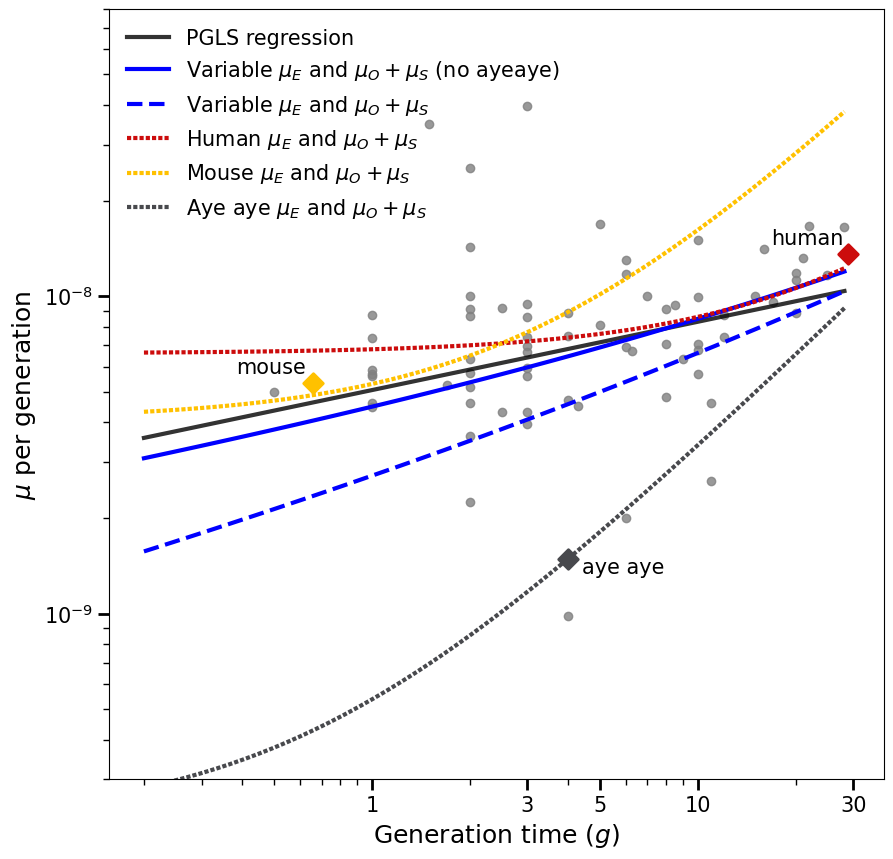

In [14]:
plot_longevity_model_prediction_per_generation(df_vertebrate, vertebrate_group_name2idx_map, cmap, save_figure=True)

## Figure 5
This following section plots figure 5, which contains the regression of N_e on generation time (panel a), qualitative relationship between N_e * g vs g (panel b), the regression of mutation rate per year on N_e * g (panel c)

In [8]:
def get_Ne_bounds(df):
    ''' get the minimum and maximum Ne and Ne for all species in the dataframe'''
    def get_min_and_max(df, column_name):
        return np.array([np.min(df[column_name]), np.max(df[column_name])])
        
    bounds_dict = dict()
    bounds_dict["Ne"] = get_min_and_max(df, "Ne")
    bounds_dict["Ne*gen"] = get_min_and_max(df, "Ne*gen")
    return bounds_dict 

def plot_dbh_mu_vs_Ne(df, group_name2idx_map, colors, mutation_rate_unit, ne_unit, ax=None, add_legend=True, label_fontsize=15):
    """helper function, plot mutation rate vs effective population size, given the unit for mu and Ne"""
    mu_key = "u_mean" if mutation_rate_unit == "generation" else "u_mean_year"
    ne_key = "Ne" if ne_unit == "Ne" else "Ne*gen"
    if ax is None:
        fig, ax = plt.subplots()
        
    # due to renaming in preprocessing to stay consistent with phylogenetic tree
    df_human = df.loc[df.index[df["species"] == "Homo sapiens neanderthalensis"]]
    human_ne, human_mu = df_human[ne_key].to_numpy()[0], df_human[mu_key].to_numpy()[0]
    df_mice = df.loc[df.index[df["species"] == "Mus musculus musculus"]]
    mice_ne, mice_mu = df_mice[ne_key].to_numpy()[0], df_mice[mu_key].to_numpy()[0]
    ax.scatter(human_ne, human_mu, color=colors[group_name2idx_map["primates"]], # edgecolor="black",
               marker='D', s=100, lw=2, zorder=float("inf")) #label="human"
    ax.scatter(mice_ne, mice_mu, color=colors[group_name2idx_map["mammals"]], # edgecolor="blue",
               marker='D', s=100, lw=2, zorder=float("inf")) #label="mice"
    offset_factor=1.1
    ax.text(0.25 * human_ne, 0.85 * human_mu, "human", zorder=float("inf"), fontsize=15)
    ax.text(1.1 * mice_ne, 1.1 * mice_mu, "mouse", zorder=float("inf"), fontsize=15)
    
    for idx, gn in enumerate(group_name2idx_map.keys()):
        df_gn = df.loc[df.index[df["group2"] == gn]]
        if gn == "mammals":
            gn = "non-primate mammals"
        ax.scatter(df_gn[ne_key], df_gn[mu_key], color=colors[idx], label=gn)
    
    if add_legend:
        ax.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
    ax.set_xscale("log")
    ax.set_yscale("log")
    
    xlabel = r"$N_e$" if ne_unit == "Ne" else r"$N_e \times g$" 
    ylabel = r"Mutation rate per generation ($\mu$)"  if mutation_rate_unit == "generation" else r"Mutation rate per year ($\mu/g$)" 
    ax.set_xlabel(xlabel, fontsize=label_fontsize)# , weight="bold")
    ax.set_ylabel(ylabel, fontsize=label_fontsize) 
    ax.tick_params(axis='both', which='major', labelsize=label_fontsize)
    
    # grid line
    ax.grid(which="major", linestyle = "dashed")
    ax.set_axisbelow(True)

def plot_Ne_vs_generation_time(df, group_name2idx_map, cmap, label_font_size=15, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))
    num_groups = len(group_name2idx_map)
    colors = [cmap(get_color_index(num_groups, i)) for i in range(num_groups)]
    df_human = df.loc[df.index[df["species"] == "Homo sapiens neanderthalensis"]]
    human_gen, human_ne = df_human["generation_time_year"].to_numpy()[0], df_human["Ne"].to_numpy()[0]
    
    df_mouse = df.loc[df.index[df["species"] == "Mus musculus musculus"]]
    mouse_gen, mouse_ne = df_mouse["generation_time_year"].to_numpy()[0], df_mouse["Ne"].to_numpy()[0]
    
    ax.scatter(human_gen, human_ne, color=colors[group_name2idx_map["primates"]], #edgecolor="black", 
               marker='D', s=100, lw=2, zorder=float("inf")) #label="human"
    ax.scatter(mouse_gen, mouse_ne, color=colors[group_name2idx_map["mammals"]], #edgecolor="blue", 
               marker='D', s=100, lw=2, zorder=float("inf")) #label="mice"
    
    ax.text(0.38 * human_gen, 0.85 * human_ne, "human", zorder=float("inf"), fontsize=15)
    ax.text(1.12 * mouse_gen, 0.82 * mouse_ne, "mouse", zorder=float("inf"), fontsize=15)

    gen_min, gen_max = np.inf, -1
    for idx, gn in enumerate(group_name2idx_map.keys()):
        df_gn = df.loc[df.index[df["group2"] == gn]]
        label = gn if gn != "mammals" else "non-primate mammals"
        gen_time = df_gn["generation_time_year"].to_numpy()
        gen_min = min(gen_min, np.min(gen_time))
        gen_max = max(gen_max, np.max(gen_time))
        
        Ne = df_gn["Ne"].to_numpy()
        ax.scatter(gen_time, Ne, color=colors[idx], label=label)
    gen_bounds = np.array([gen_min, gen_max])
        
    box = ax.get_position()
    ax.set_xlabel(r"Generation time $g$ (years)", fontsize=label_font_size) 
    ax.set_ylabel(r"Effective population size ($N_e$)", fontsize=label_font_size) # $\mathbf{N_e}$
    ax.tick_params(axis='both', which='major', labelsize=13)
    return gen_bounds

def plot_Ne_times_g(regression_slope, gen_bounds, label_font_size=15, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    g = np.linspace(gen_bounds[0], gen_bounds[1], num=50)
    gNe = np.power(g, 1 + regression_slope)

    Ne = 5 * np.power(g, regression_slope) # 5 is an scaling factor to make the two curves look on about the same scale
    ax.text(0.68 * g[-1], 0.95 * gNe[-1], r"$g \times N_e$", fontsize=15)
    ax.text(0.8 * g[-1], 1.2 * Ne[-1], r"$N_e$", fontsize=15)

    ax.plot(g, gNe)
    ax.plot(g, Ne)
    ax.set_xlabel(r'Generation time $g$ (years)', fontsize=label_font_size)
    ax.tick_params(axis='y', which='both',labelsize=0, length=0)
    ax.tick_params(axis='x', which='major', labelsize=13)
    bottom, _ = ax.get_ylim()

    y_val_max = max([np.max(Ne), np.max(gNe)])
    ax.set_ylim([bottom, y_val_max * 1.1])

def generate_manuscript_figure_5(df, group_name2idx_map, cmap, save_figure=False):
    num_groups = len(group_name2idx_map)
    colors = [cmap(get_color_index(num_groups, i)) for i in range(num_groups)]

    fig, ax = plt.subplots(1,3, figsize=(15,5))
    gen_bounds = plot_Ne_vs_generation_time(df, group_name2idx_map, cmap, ax=ax[0], label_font_size=15)
    r_filename = f"./output/r/Ne_vs_gen.csv"
    [_, slope] = load_and_plot_r_regression_output(r_filename, gen_bounds, text_pos=(0.5, 0.85), fontsize=15, log_scale=True, ax=ax[0], 
                                      label=None, linestyle="dashed", linewidth=1, alpha=1, color="black")
    ax[0].set_xscale("log")
    ax[0].set_yscale("log")
    tick_location = [1,3,5,10,30]
    ax[0].set_xticks(tick_location, labels=tick_location)
    fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0), fontsize=13, ncol=3) 
    
    # panel B
    plot_Ne_times_g(slope, gen_bounds, ax=ax[1], label_font_size=15)

    # panel C: dbh plot of mutation rate per year vs Ne * generation_time
    ne_bounds = get_Ne_bounds(df)
    plot_dbh_mu_vs_Ne(df, group_name2idx_map, colors, "year", "Ne*gen", ax=ax[2], add_legend=False, label_fontsize=15)
    ax[2].set_ylim([10**(-9.82), 10**(-7.3)])
    r_filename = f"./output/r/dbh_vertebrate_u_year_vs_Negen.csv"
    _ = load_and_plot_r_regression_output(r_filename, ne_bounds["Ne*gen"], text_pos=(0.5, 0.85), fontsize=15, log_scale=True, ax=ax[2], 
                                      label=None, linestyle="dashed", linewidth=1, alpha=1, color="black")
        
    fig.tight_layout()

    for n, axis in enumerate(ax.flatten()):
        axis.text(0.02, 0.94, string.ascii_uppercase[n], transform=axis.transAxes, size=20) 
    if save_figure:
        fig.savefig("figures/figure5_vertebrate_DBH.pdf", bbox_inches='tight')

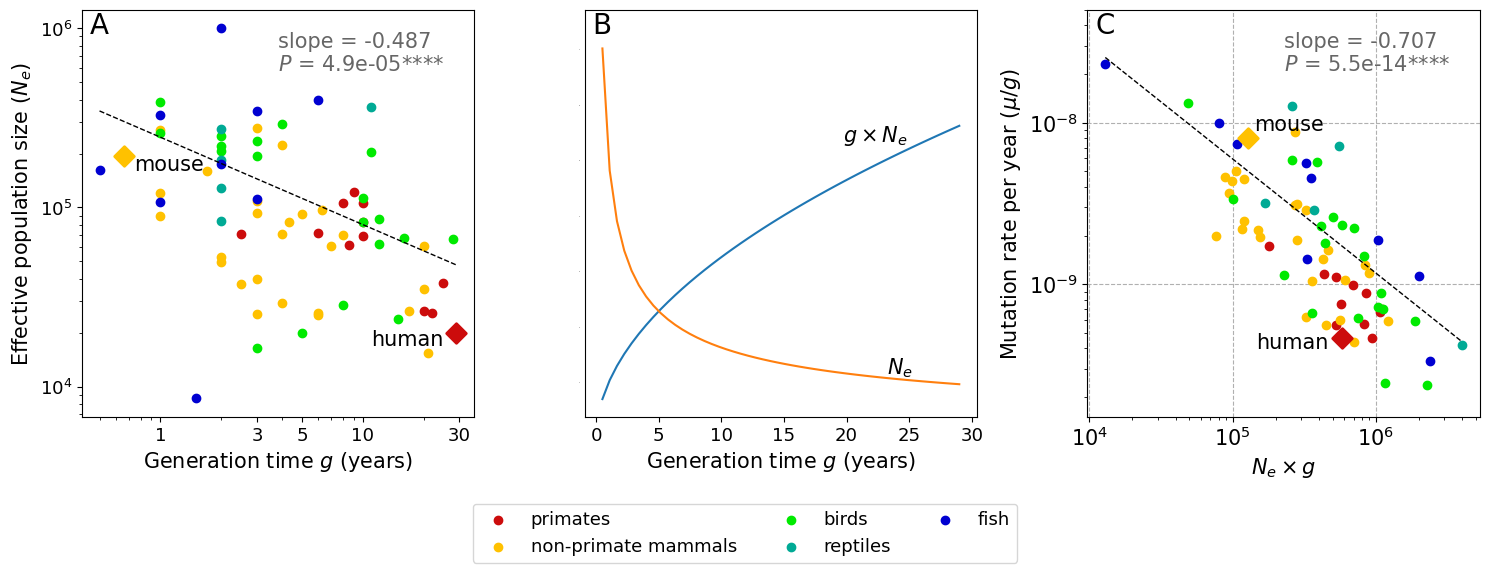

In [45]:
generate_manuscript_figure_5(df_vertebrate, vertebrate_group_name2idx_map, cmap, save_figure=True)

## Compare log scale vs linear scale data (Supplementary figure 2)

In [29]:
def calculate_lognorm_params(input):
    # https://stackoverflow.com/questions/8870982/how-do-i-get-a-lognormal-distribution-in-python-with-mu-and-sigma
    s, scale = np.var(input), np.exp(np.mean(input))
    rv = stats.lognorm(s, scale=scale)
    return [s, scale, rv]

def calculate_normal_params(input):
    mu, std = np.mean(input), np.std(input)
    rv = stats.norm(mu, std)
    return [mu, std, rv]    

def plot_helper(data, ax):
    x_data = np.linspace(np.min(data), np.max(data), 100)
    log_data = np.log(data)
    [_, _, rv_lognorm] = calculate_lognorm_params(log_data)
    [mean_norm, _, rv_norm] = calculate_normal_params(data)
    x_norm = np.linspace(2 * mean_norm - np.max(data), np.max(data), 100)

    ax.hist(data, density=True)
    ax.plot(x_data, rv_lognorm.pdf(x_data), 'k-', lw=2, label="fitted log-normal")
    ax.plot(x_norm, rv_norm.pdf(x_norm), 'r-', lw=2, label="fitted normal")
    ax.legend()

def plot_data_and_fit_lognormal_distribution(df, save_figure=False):
    fig, ax = plt.subplots(1,2, figsize=(10,5))

    gen = df["generation_time_year"].to_numpy()
    plot_helper(gen, ax[0])
    ax[0].set_xlabel("Generation time (years)", fontsize=15)

    mu_g = df["u_mean"].to_numpy()
    plot_helper(mu_g, ax[1])
    ax[1].set_xlabel(r"$\mu$ per generation", fontsize=15)
    
    for i in range(2):
        ax[i].tick_params(axis='both', which='major', labelsize=15)

    for n, axis in enumerate(ax.flatten()):
        axis.text(0.02, 0.94, string.ascii_uppercase[n], transform=axis.transAxes, size=20, weight='bold')

    fig.tight_layout()
    
    if save_figure:
        fig.savefig("figures/supp_figure2_lognormal_distribution.pdf", bbox_inches='tight')

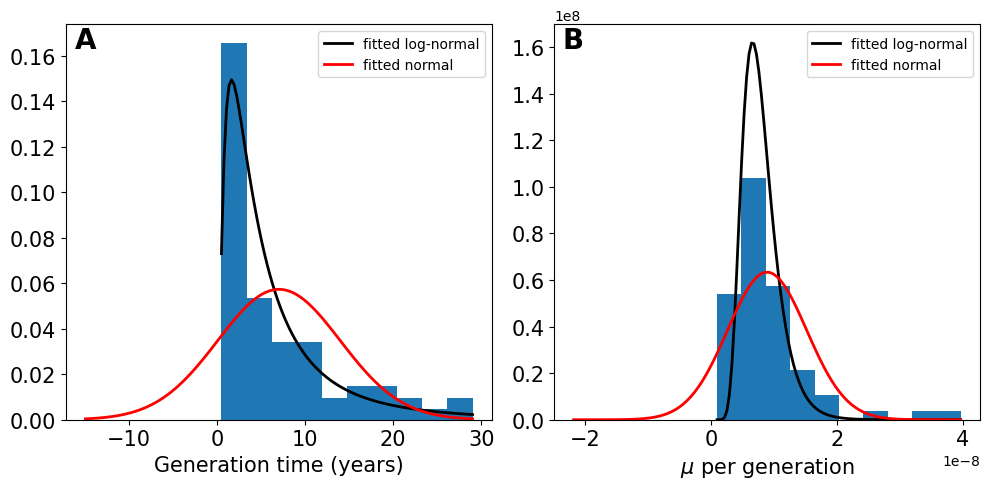

In [30]:
plot_data_and_fit_lognormal_distribution(df_vertebrate, save_figure=True)

## Regression of age at first reproduction (AFR, as proxy for age of puberty) vs generation time (Supplementary figure 3)
Dataset taken from paper "Generation Length for Mammals". The regression is performed on species whose generation time was available on the IUCN Red List

In [31]:
def load_and_filter_generation_time_mammal_data():
    df = pd.read_excel("./data/generation_time_for_mammals/Generation Length for Mammals.xlsx")
    df_gma = df[df["Sources_GL"] == "GMA"]
    print(f"{len(df_gma)} species where generation time is provided by IUCN Red List")
    df_gma_afr = df_gma[df_gma["AFR_d"] != "no information"]
    print(f"{len(df_gma_afr)} species left after filtering for species where AFR_d had no information")
    data = df_gma_afr[["AFR_d", "GenerationLength_d"]].to_numpy().astype("float32")
    data /= 365
    gen_min, gen_max = np.min(data[:,1]), np.max(data[:,1])
    print(f"Range of generation time: {gen_min} - {gen_max}")
    return data

def plot_and_regress_age_of_puberty_vs_generation_time(data, save_figure=False):
    fig, ax = plt.subplots()
    afr, gen_time = data[:,0], data[:,1] 
    gen_min, gen_max = np.min(gen_time), np.max(gen_time)
    ax.scatter(gen_time, afr)
    ax.set_xlabel("generation time (years)", fontsize=15)
    ax.set_ylabel("age at first reproduction (years)", fontsize=15)
    ax.tick_params(axis='both', which='major', labelsize=15)
    
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(gen_time, afr)
    print(f"slope={slope}, intercept={intercept}, r-value: {r_value}, p-value: {p_value}")
    reg_fn = np.poly1d([slope, intercept])
    gen_arr = np.linspace(gen_min, gen_max, 1000)
    ax.plot(gen_arr, reg_fn(gen_arr), '--k')

    if save_figure:
        fig.savefig("figures/supp_figure3_age_of_puberty_vs_generation_time.pdf", bbox_inches='tight')

439 species where generation time is provided by IUCN Red List
230 species left after filtering for species where AFR_d had no information
Range of generation time: 2.0 - 52.0
slope=0.4187745108094837, intercept=-0.7095257085600268, r-value: 0.8696168106782604, p-value: 7.899894044403887e-72


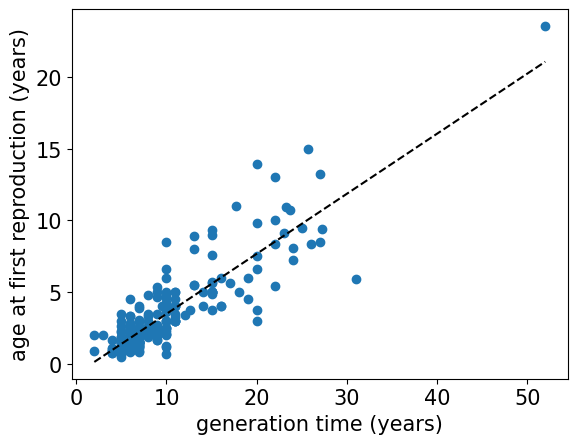

In [32]:
mammal_afr_gen_time = load_and_filter_generation_time_mammal_data()
plot_and_regress_age_of_puberty_vs_generation_time(mammal_afr_gen_time, save_figure=True)

# Supplementary Tables

In [108]:
def parse_figure2_ouput_data_filename(filename):
    basename = os.path.basename(filename)
    temp = basename.split(".")[0].split("_")
    dataset_name = temp[:2]
    if temp[0] == "wang":
        baboon_source = "Wang 2024"
    elif temp[0] == "wu":
        baboon_source = "Wu 2020"
    else:
        raise Exception("Unknown dataset")
    
    if temp[1] == "wang":
        aye_aye_source = "Wang 2024"
    elif temp[1] == "versoza":
        aye_aye_source = "Versoza 2024"
    else:
        raise Exception("Unknown dataset")

    dataset_str = f"Aye aye ({aye_aye_source}), Baboon ({baboon_source})"
    if temp[-2] == "variable":
        ratio_str = "likelihood estimate mu_S/(mu_S + mu_O)"
    elif temp[-2] == "default":
        ratio_str = "3:1 mu_S/(mu_S + mu_O)"
    return [dataset_str, ratio_str]

def supplementary_table_one():
    file_dir = "./output/r/figure2_df/"
    df_list = []
    for filename in glob.glob(f"{file_dir}/*combined*.csv"):
        [dataset_str, ratio_str] = parse_figure2_ouput_data_filename(filename)
        # replace the "3:1" string in dataset_str to "constant 0.75"
        ratio_str = ratio_str.replace("3:1", "constant 0.75")
        # remove the end of the string "mu_S/(mu_S + mu_O)" from ratio_str
        ratio_str = ratio_str.replace(" mu_S/(mu_S + mu_O)", "")
        # print(f"Dataset: {dataset_str}, alpha: {ratio_str}")
        model_name = [
             "log(mu_E) ~ log(generation_time)", 
             "log(mu_S + mu_O) ~ log(generation_time)", 
             "log(mu_generation) ~ log(generation_time)"
             # "log(pre_puberty_load_per_site_generation) ~ log(generation_time)", 
             # "log(gamete_mutation_rate_per_site_per_year) ~ log(generation_time)", 
             # "log(germline_mutation_rate_per_site_generation) ~ log(generation_time)"
             ]
        df = pd.read_csv(filename)
        df["model"] = model_name
        df["source of aye aye and baboon dataset"] = f"{dataset_str}"
        df["source of mu_S/(mu_S+mu_O)"] = f"{ratio_str}"
        df = df[["source of aye aye and baboon dataset", "source of mu_S/(mu_S+mu_O)", "model", "lambda", "intercept", "intercept.p", "slope", "slope.p"]]
        df_list.append(df)
    df_combined = pd.concat(df_list, ignore_index=True)

    excel_filename = "./Supplementary_tables.xlsx"

    # Supplementary Table 1: Regression results of log(mu_E), log(mu_S + mu_O) and log(total mutation rate) vs log(generation time) with different permutations of Aye aye and Baboon dataset, and likelihood-inferred vs constant mu_S/(mu_S+mu_O)
    with pd.ExcelWriter(excel_filename, engine='openpyxl', mode='a', if_sheet_exists="overlay") as writer:
        workbook = writer.book
        try:
            sheet = workbook['Supplementary Table 1']
        except KeyError:
            sheet = workbook.create_sheet("Supplementary Table 1")
        sheet["A1"] = "Supplementary Table 1: Regression results of log(mu_E), log(mu_S + mu_O) and log(total mutation rate) vs log(generation time) with different permutations of Aye aye and Baboon dataset, and likelihood-inferred vs constant mu_S/(mu_S+mu_O)"
        df_combined.to_excel(writer, sheet_name='Supplementary Table 1', index=False, startrow=1)

supplementary_table_one()

In [97]:
def supplementary_table_two_and_three():
    # prints the individual regression results into supplementary table 2 (variable alpha) and 3 (constant 3:1 alpha)
    df_var = pd.read_csv("output/individual_species_regression_result_variable_alpha.csv")
    df_var = df_var.rename(columns={'Unnamed: 0': 'Species'})
    df_const = pd.read_csv("output/individual_species_regression_result_default_alpha.csv")
    df_const = df_const.rename(columns={'Unnamed: 0': 'Species'})
    excel_filename = "./Supplementary_tables.xlsx"
    with pd.ExcelWriter(excel_filename, engine='openpyxl', mode='a', if_sheet_exists="overlay") as writer:
        workbook = writer.book
        try:
            sheet = workbook['Supplementary Table 2']
        except KeyError:
            sheet = workbook.create_sheet("Supplementary Table 2")
        sheet["A1"] = "Supplementary Table 2: Poisson regression for individual species using likelihood inferred mu_S/(mu_S + mu_O)"
        df_var.to_excel(writer, sheet_name='Supplementary Table 2', index=False, startrow=1)

    with pd.ExcelWriter(excel_filename, engine='openpyxl', mode='a', if_sheet_exists="overlay") as writer:
        workbook = writer.book
        try:
            sheet = workbook['Supplementary Table 3']
        except KeyError:
            sheet = workbook.create_sheet("Supplementary Table 3")
        sheet["A1"] = "Supplementary Table 3: Poisson regression for individual species using constant 3:1 mu_S/(mu_S + mu_O)"
        df_const.to_excel(writer, sheet_name='Supplementary Table 3', index=False, startrow=1)
supplementary_table_two_and_three()

In [95]:
def load_r2_optimized_paternal_maternal_ratios(filename):
    df = pd.read_csv(filename)
    return df

def supplementary_table_four():
    # table that compares the likelihood based estimates of mu_S/(mu_S + mu_O) vs literature alpha values
    df = pd.read_csv("output/r/likelihood_paternal_maternal_ratios.csv")
    # change header name for ratio to likelihood mu_S/(mu_S + mu_O)
    df["ratio"] = df["ratio"].apply(lambda x: float('{0:.3f}'.format(float(x))))
    df = df.rename(columns={"ratio": "likelihood inferred mu_S/(mu_S + mu_O)"})
    df.loc[df["species"] == "Aye aye", "species"] = "Aye aye (Wang)"
    df.loc[df["species"] == "Baboon", "species"] = "Baboon (Wang)"
    df["ratio of paternally phased mutations from literature"] = [float(f"{n:.3f}") for n in [1.26/2.26, 205/(205+51), 93/(93+31), 4.37/(4.37+1), 0.804, 0.763, 2.76/3.76, 2.09/3.09]]
    
    df_ayeaye_versoza = pd.DataFrame([["Aye aye (Versoza)", "NA", 27/37]], columns=["species", "likelihood inferred mu_S/(mu_S + mu_O)", "ratio of paternally phased mutations from literature"])
    df_concat = pd.concat([df_ayeaye_versoza, df], axis=0, ignore_index=True)
    
    df_r2 = pd.read_csv("output/paternal_maternal_ratio_r2_result.csv")
    df_r2.loc[df_r2["species"] == "Mouse", "pseudo r2 based inference of mu_S/(mu_S + mu_O)"] = np.nan
    df_final = pd.merge(df_concat, df_r2, on="species")

    with pd.ExcelWriter("Supplementary_tables.xlsx", engine='openpyxl', mode='a', if_sheet_exists="overlay") as writer:
        workbook = writer.book
        try:
            sheet = workbook['Supplementary Table 4']
        except KeyError:
            sheet = workbook.create_sheet("Supplementary Table 4")
        sheet['A1'] = "Supplementary Table 4: Inferred mu_S/(mu_S + mu_O) vs literature values"
        sheet['D10'] = "NA" # change mouse value to NA
        df_final.to_excel(writer, sheet_name='Supplementary Table 4', index=False, startrow=1)
        sheet["A12"] = "Note: mouse result is missing from pseudo r2 based inference since the paternal and maternal are identical for offsprings, causing the mu_S/(mu_S+mu_O) to be unidentifiable. Aye aye versoza result is missing from the likelihood inference since the dataset did not contain enough phased mutations"
supplementary_table_four()

In [96]:
def supplementary_table_five():
    df_list = []
    for filename in glob.glob("./output/batch_effect_results/batch_effect*.csv"):
        basename = os.path.basename(filename)
        dataset_name = basename.split(".")[0].split("_")[2]
        dataset2species_map = {
            "Wang vs Wu": "Baboon (Wang vs Wu)",
            "Versoza vs Wang": "Aye aye (Versoza vs Wang)",
            "Jonsson vs Wu": "Human (Jonsson vs Wu)",
            "Bergeron vs Wang": "Macaque (Bergeron vs Wang)",
        }
        row_name_str = f"{dataset2species_map[dataset_name]} ({dataset_name})"
        df = pd.read_csv(filename)
        df = df.replace({"Unnamed: 0": dataset2species_map})
        df = df.rename(columns={'Unnamed: 0': 'Species (datasets)'})
        df_list.append(df)
    df_combined = pd.concat(df_list, ignore_index=True)

    # 
    with pd.ExcelWriter("Supplementary_tables.xlsx", engine='openpyxl', mode='a', if_sheet_exists="overlay") as writer:
        workbook = writer.book
        try:
            sheet = workbook['Supplementary Table 5']
        except KeyError:
            sheet = workbook.create_sheet("Supplementary Table 5")
        sheet["A1"] = "Supplementary Table 5: categorical regression results to test for batch effect between different datasets of the same species"
        df_combined.to_excel(writer, sheet_name='Supplementary Table 5', index=False, startrow=1)
    
supplementary_table_five()